In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
from corner import corner

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import plot_util, overplot
from mejiro.utils import util

In [2]:
def get_detectable_subhalo_params(detectable_subhalos):
    """
    Returns the redshift, mass, and concentration of detectable subhalos
    """
    z_list, m_list, c_list = [], [], []
    for halo_list in detectable_subhalos:
        for z, m, c in halo_list:
            z_list.append(z)
            m_list.append(m)
            c_list.append(c)
    return z_list, m_list, c_list

In [3]:
hlwas_save_dir = os.path.join(config.machine.data_dir, 'output', 'subhalo_detection_compare_hlwas')
hlwas_detectable_halos = util.unpickle_all(hlwas_save_dir, 'detectable_halos_', '.pkl')
hlwas_z_list, hlwas_m_list, hlwas_c_list = get_detectable_subhalo_params(hlwas_detectable_halos)

hltds_wide_dir = os.path.join(config.machine.data_dir, 'output', 'subhalo_detection_compare_hltds_wide')
hltds_wide_detectable_halos = util.unpickle_all(hltds_wide_dir, 'detectable_halos_', '.pkl')
hltds_wide_z_list, hltds_wide_m_list, hltds_wide_c_list = get_detectable_subhalo_params(hltds_wide_detectable_halos)

hltds_deep_save_dir = os.path.join(config.machine.data_dir, 'output', 'subhalo_detection_compare_hltds_deep')
hltds_deep_detectable_halos = util.unpickle_all(hltds_deep_save_dir, 'detectable_halos_', '.pkl')
hltds_deep_z_list, hltds_deep_m_list, hltds_deep_c_list = get_detectable_subhalo_params(hltds_deep_detectable_halos)

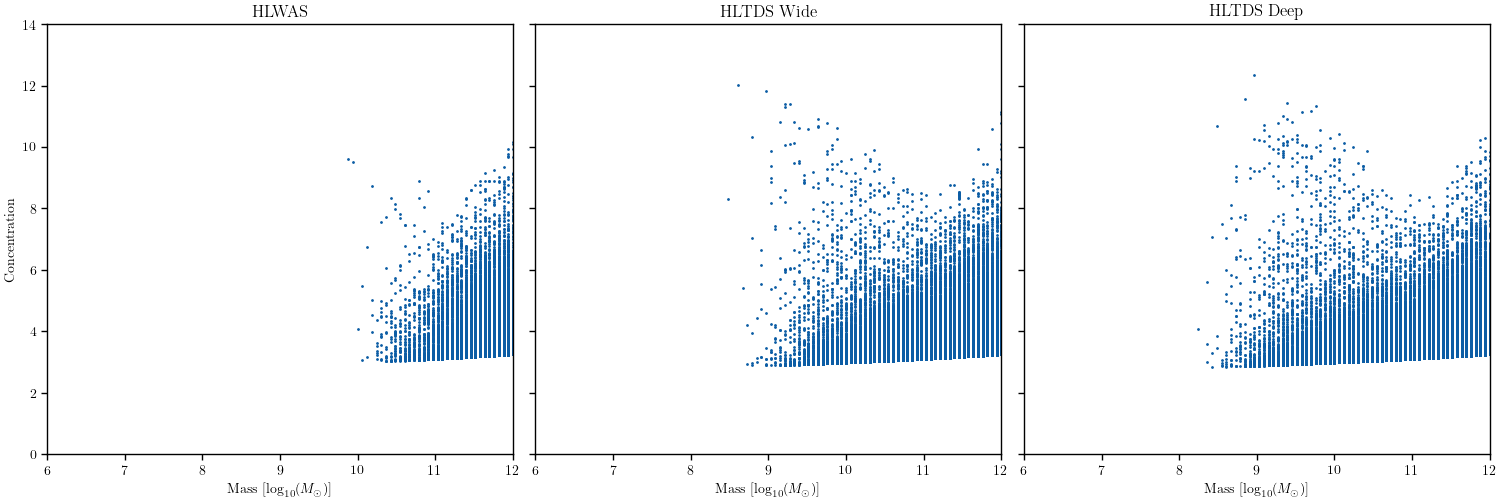

In [4]:
f, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True, constrained_layout=True)

ax[0].scatter(np.log10(hlwas_m_list), hlwas_c_list, s=1, label='HLWAS')
ax[0].set_ylim(0, 14)
ax[0].set_ylabel('Concentration')
ax[0].set_title('HLWAS')

ax[1].scatter(np.log10(hltds_wide_m_list), hltds_wide_c_list, s=1, label='HLTDS Wide')
ax[1].set_title('HLTDS Wide')

ax[2].scatter(np.log10(hltds_deep_m_list), hltds_deep_c_list, s=1, label='HLTDS Deep')
ax[2].set_title('HLTDS Deep')

for a in ax.flatten():
    a.set_xlabel(r'Mass [$\log_{10}(M_{\odot})$]')
    a.set_xlim(6, 12)

plt.show()

In [5]:
def get_percent_detectable(m_list, detectable_halos):
    percent_det = []
    mlog10_list = [np.log10(m) for m in np.logspace(6, 12, 100)]
    m_list = [np.log10(m) for m in m_list]

    for m in mlog10_list:
        count = np.sum(np.array(m_list) == m)
        percent_det.append(count / len(detectable_halos))

    return percent_det

In [6]:
hlwas_percent_detectable = get_percent_detectable(hlwas_m_list, hlwas_detectable_halos)
hltds_wide_percent_detectable = get_percent_detectable(hltds_wide_m_list, hltds_wide_detectable_halos)
hltds_deep_percent_detectable = get_percent_detectable(hltds_deep_m_list, hltds_deep_detectable_halos)

In [7]:
# Nightningale2023 detections, minus the one that's more likely to be a line-of-sight halo
bells = [11.95, 8.65]
slacs = [11.75, 11.12]

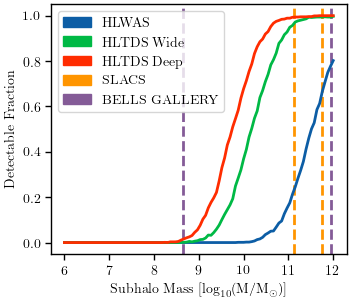

In [8]:
import matplotlib.patches as mpatches

patch_0 = mpatches.Patch(color='C0', label='HLWAS')
patch_1 = mpatches.Patch(color='C1', label='HLTDS Wide')
patch_2 = mpatches.Patch(color='C3', label='HLTDS Deep')
patch_3 = mpatches.Patch(color='C2', label='SLACS')
patch_4 = mpatches.Patch(color='C4', label='BELLS GALLERY')

mlog10_list = [np.log10(m) for m in np.logspace(6, 12, 100)]

plt.figure(figsize=(3.5, 3), constrained_layout=True)
for m in bells:
    plt.axvline(m, color='C4', linestyle='--')
for m in slacs:
    plt.axvline(m, color='C2', linestyle='--')
plt.plot(mlog10_list, hlwas_percent_detectable, color='C0')
plt.plot(mlog10_list, hltds_wide_percent_detectable, color='C1')
plt.plot(mlog10_list, hltds_deep_percent_detectable, color='C3')
plt.ylabel('Detectable Fraction')
plt.xlabel(r'Subhalo Mass [$\log_{10}($M/M$_\odot)$]')
plt.legend(handles=[patch_0, patch_1, patch_2, patch_3, patch_4])
plt.savefig(os.path.join(figure_dir, 'subhalo_detection_compare.png'))
plt.show()

In [9]:
hst_masses = [11.91, 11.12, 11.75, 11.95]
hst_zs = [0.2219, 0.2270, 0.1045, 0.4980]

In [10]:
# f, ax1 = plt.subplots(figsize=(3.5, 3.5))
# ax1.hist(roman_masses, bins=20, alpha=0.5, label='Roman', histtype='step', weights=plot_util.weights(roman_masses))
# ax1.hist(hst_masses, bins=20, alpha=0.5, label='HST', histtype='step', weights=plot_util.weights(hst_masses))
# ax1.set_xlabel('Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
# ax1.set_ylabel('Probability Density')

# ax2 = ax1.twiny()
# ax2.hist(roman_zs, bins=20, alpha=0.5, label='Roman', weights=plot_util.weights(roman_zs))
# ax2.hist(hst_zs, bins=20, alpha=0.5, label='HST', weights=plot_util.weights(hst_zs))
# ax2.set_xlabel('Subhalo Redshift')

# plt.legend()
# plt.show()

In [11]:
# q_low = 0.16
# q_mid = 0.5
# q_high = 0.84

# roman_masses_q = np.quantile(roman_masses, [q_low, q_mid, q_high])
# hst_masses_q = np.quantile(hst_masses, [q_low, q_mid, q_high])
# roman_zs_q = np.quantile(roman_zs, [q_low, q_mid, q_high])
# hst_zs_q = np.quantile(hst_zs, [q_low, q_mid, q_high])

# roman_mass_high = roman_masses_q[2] - roman_masses_q[1]
# roman_mass_low = roman_masses_q[1] - roman_masses_q[0]
# hst_mass_high = hst_masses_q[2] - hst_masses_q[1]
# hst_mass_low = hst_masses_q[1] - hst_masses_q[0]
# roman_z_high = roman_zs_q[2] - roman_zs_q[1]
# roman_z_low = roman_zs_q[1] - roman_zs_q[0]
# hst_z_high = hst_zs_q[2] - hst_zs_q[1]
# hst_z_low = hst_zs_q[1] - hst_zs_q[0]

# print(f'{roman_masses_q[1]:.2f} +{roman_mass_high:.2f} -{roman_mass_low:.2f}')
# print(f'{hst_masses_q[1]:.2f} +{hst_mass_high:.2f} -{hst_mass_low:.2f}')
# print(f'{roman_zs_q[1]:.2f} +{roman_z_high:.2f} -{roman_z_low:.2f}')
# print(f'{hst_zs_q[1]:.2f} +{hst_z_high:.2f} -{hst_z_low:.2f}')

In [12]:
# f, ax = plt.subplots(1, 2, figsize=(6, 2.5), sharey=True, constrained_layout=True)

# binwidth = 0.2
# bins = np.arange(min(roman_masses + hst_masses), max(roman_masses + hst_masses) + (binwidth / 2), binwidth)
# # ax[0].hist(roman_masses, bins=bins)
# ax[0].hist(roman_masses, label=f'Roman Forecast: {roman_masses_q[1]:.2f}' + r'$\substack{+0.44 \\ -0.73}$', bins=bins, histtype='step', weights=plot_util.weights(roman_masses))  # weights=plot_util.weights(roman_masses), 
# # ax[0].hist(hst_masses, label=f'HST: {hst_masses_q[1]:.2f}' + r'$\substack{+0.17 \\ -1.52}$', bins=bins, weights=plot_util.weights(hst_masses))  # weights=plot_util.weights(hst_masses), 
# # ax[0].axvline(roman_masses_q[0], color='C0', linestyle=':')
# # ax[0].axvline(roman_masses_q[1], color='C0', linestyle='--')
# # ax[0].axvline(roman_masses_q[2], color='C0', linestyle=':')
# # ax[0].axvline(hst_masses_q[1], color='C1', linestyle='--')
# ax[0].set_xlabel('Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
# ax[0].set_ylabel('Probability Density')
# # ax[0].set_yscale('log')
# # ax[0].set_ylim(0, 0.6)
# ax[0].legend(loc='upper left')

# binwidth = 0.05
# bins = np.arange(min(roman_zs + hst_zs), max(roman_zs + hst_zs) + (binwidth / 2), binwidth)
# # ax[1].hist(roman_zs, bins=bins)
# ax[1].hist(roman_zs, label=f'Roman Forecast: {roman_zs_q[1]:.2f}' + r'$\substack{+0.20 \\ -0.17}$', bins=bins, histtype='step', weights=plot_util.weights(roman_zs))  # , 
# # ax[1].hist(hst_zs, label=f'HST: {hst_zs_q[1]:.2f}' + r'$\substack{+0.29 \\ -0.05}$', bins=bins, weights=plot_util.weights(hst_zs))  # , 
# # ax[1].axvline(roman_zs_q[0], color='C0', linestyle=':')
# # ax[1].axvline(roman_zs_q[1], color='C0', linestyle='--')
# # ax[1].axvline(roman_zs_q[2], color='C0', linestyle=':')
# # ax[1].axvline(hst_zs_q[1], color='C1', linestyle='--')
# ax[1].set_xlabel('Subhalo Redshift')
# # ax[1].set_ylabel('Count')
# # ax[1].set_yscale('log')
# # ax[1].set_ylim(1e-1, 2e5)
# ax[1].legend(loc='upper right')

# # plt.savefig(os.path.join(figure_dir, 'subhalo_detection_compare.png'))
# plt.show()

In [13]:
# hst_detections = np.column_stack([hst_masses, hst_zs])

# hst = corner(hst_detections, labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'], color='r')

In [14]:
# roman_detections = np.column_stack([roman_masses, roman_zs])

# roman = corner(roman_detections, color='b', labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'])

In [15]:
# corner(hst_detections, labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'], color='r', fig=roman)